# Road Speed Regression Model - XGBoost

## Overview
Notebook ini mengembangkan model regresi untuk memprediksi kecepatan aktual kendaraan di jalan tambang berdasarkan kondisi jalan, cuaca, dan pola historis.

## Business Objective
- **Goal**: Prediksi kecepatan jalan untuk optimasi waktu siklus (cycle time)
- **Target Metric**: RMSE < 5 km/h
- **Impact**: Peningkatan efisiensi operasional dan perencanaan logistik

## Model Information
- **Algorithm**: XGBoost Regressor
- **Type**: Supervised Learning - Regression
- **Target Variable**: `kecepatan_aktual_km_jam`
- **Features**: Temporal, weather, lag, rolling aggregates

## Data Sources
- **Input**: `data/feature_store/infra_features.parquet`
- **Features**: ~30+ engineered features from Infrastructure Feature Engineering
- **Records**: ~12,000 road observations

## Key Performance Indicators
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² Score (Coefficient of Determination)

## MLflow Tracking
- Experiment: `infrastructure_models`
- Run Name: `road_speed_xgboost_baseline`
- Tracking URI: `http://localhost:5000`

---


## 1. Setup and MLflow Configuration

In [6]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# MLflow
import mlflow
import mlflow.xgboost

# Set project root directory
project_root = Path(r'c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml')
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Set MLflow tracking URI
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('infrastructure_models')

print("\nLibraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
experiment = mlflow.get_experiment_by_name('infrastructure_models')
if experiment:
    print(f"Experiment ID: {experiment.experiment_id}")
else:
    print("Experiment will be created on first run")


Working directory: c:\Users\I5\Documents\asah-2025\capstone-project\minewise_ml

Libraries imported successfully
XGBoost version: 3.1.2
MLflow tracking URI: http://localhost:5000
Experiment ID: 1

Libraries imported successfully
XGBoost version: 3.1.2
MLflow tracking URI: http://localhost:5000
Experiment ID: 1


## 2. Load Feature Store Data

In [7]:
print("=" * 80)
print("LOADING INFRASTRUCTURE FEATURES")
print("=" * 80)

# Load infrastructure features from feature store
features_path = 'data/feature_store/infra_features.parquet'

if not Path(features_path).exists():
    print(f"\nError: Feature file not found at {features_path}")
    print("Please run 01_Infrastructure_Features.ipynb first to generate features.")
    raise FileNotFoundError(f"Feature file not found: {features_path}")

df = pd.read_parquet(features_path)
print(f"\nData loaded successfully: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

# Check target variable
if 'kecepatan_aktual_km_jam' in df.columns:
    print(f"\nTarget variable statistics (kecepatan_aktual_km_jam):")
    print(df['kecepatan_aktual_km_jam'].describe())
    print(f"  Missing: {df['kecepatan_aktual_km_jam'].isnull().sum()} ({df['kecepatan_aktual_km_jam'].isnull().sum()/len(df)*100:.2f}%)")
else:
    raise ValueError("Target variable 'kecepatan_aktual_km_jam' not found in dataset!")

# Check for missing values
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

if missing_pct.max() > 0:
    print(f"\nMissing values (>0%):") 
    print(missing_pct[missing_pct > 0].head(10))
else:
    print(f"\nNo missing values found in dataset!")

# Date range
if 'tanggal' in df.columns:
    print(f"\nDate range: {df['tanggal'].min()} to {df['tanggal'].max()}")


LOADING INFRASTRUCTURE FEATURES

Data loaded successfully: (12000, 57)
  Rows: 12,000
  Columns: 57

Target variable statistics (kecepatan_aktual_km_jam):
count    12000.000000
mean        21.421517
std          9.577283
min          6.200000
25%         13.900000
50%         18.600000
75%         30.700000
max         39.100000
Name: kecepatan_aktual_km_jam, dtype: float64
  Missing: 0 (0.00%)

Missing values (>0%):
speed_lag_14d        1.750
speed_change_7d      0.875
cycle_time_lag_7d    0.875
speed_lag_7d         0.875
cycle_time_lag_1d    0.125
speed_lag_1d         0.125
speed_change_1d      0.125
dtype: float64


## 3. Feature Selection & Preprocessing

In [8]:
print("=" * 80)
print("FEATURE SELECTION & PREPROCESSING")
print("=" * 80)

# Define target variable
target = 'kecepatan_aktual_km_jam'

# Exclude non-predictive columns
exclude_cols = [
    'tanggal',                      # Identifier (datetime)
    'id_segmen',                    # Identifier
    'nama_segmen',                  # Identifier (categorical)
    'kecepatan_aktual_km_jam',      # Target variable
    'waktu_tempuh_menit',           # Related target (avoid leakage)
    'status_jalan',                 # Categorical (for classification model)
]

# Add any non-numeric columns to exclude
for col in df.columns:
    if df[col].dtype == 'object' and col not in exclude_cols:
        exclude_cols.append(col)

# Select feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal columns: {len(df.columns)}")
print(f"Excluded columns: {len(exclude_cols)}")
print(f"Feature columns: {len(feature_cols)}")

# Handle missing values
X = df[feature_cols].copy()
y = df[target].copy()

# Save tanggal column for temporal splitting (before preprocessing)
if 'tanggal' in df.columns:
    tanggal_series = df['tanggal'].copy()
else:
    # If tanggal not available, use index for split
    tanggal_series = None
    print("\nWarning: 'tanggal' column not found. Using sequential split instead.")

print(f"\nInitial shape: X={X.shape}, y={y.shape}")

# Fill missing values with median for numeric columns
missing_before = X.isnull().sum().sum()
for col in X.select_dtypes(include=[np.number]).columns:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)

missing_after = X.isnull().sum().sum()
print(f"Missing values filled: {missing_before} -> {missing_after}")

# Ensure all features are numeric
X = X.select_dtypes(include=[np.number])

print(f"\nFinal shape: X={X.shape}, y={y.shape}")
print(f"Features prepared: {X.shape[1]} features")
print(f"Target samples: {len(y)}")

# Categorize features
temporal_features = [c for c in X.columns if any(x in c.lower() for x in ['hour', 'day', 'shift', 'weekend', 'month'])]
weather_features = [c for c in X.columns if any(x in c.lower() for x in ['rainfall', 'rain', 'wet', 'weather', 'humidity'])]
lag_features = [c for c in X.columns if 'lag' in c.lower()]
rolling_features = [c for c in X.columns if any(x in c.lower() for x in ['rolling', 'avg', 'mean', 'std'])]
road_features = [c for c in X.columns if any(x in c.lower() for x in ['jalan', 'road', 'kondisi', 'maintenance'])]

print(f"\nFeature Categories:")
print(f"  Temporal: {len(temporal_features)} features")
print(f"  Weather: {len(weather_features)} features")
print(f"  Lag: {len(lag_features)} features")
print(f"  Rolling: {len(rolling_features)} features")
print(f"  Road: {len(road_features)} features")
other_count = X.shape[1] - len(temporal_features) - len(weather_features) - len(lag_features) - len(rolling_features) - len(road_features)
print(f"  Other: {other_count} features")


FEATURE SELECTION & PREPROCESSING

Total columns: 57
Excluded columns: 18
Feature columns: 42


Initial shape: X=(12000, 42), y=(12000,)
Missing values filled: 570 -> 0

Final shape: X=(12000, 38), y=(12000,)
Features prepared: 38 features
Target samples: 12000

Feature Categories:
  Temporal: 9 features
  Weather: 6 features
  Lag: 7 features
  Rolling: 5 features
  Road: 1 features
  Other: 10 features


## 4. Train-Test Split (Temporal)

In [9]:
print("=" * 80)
print("TRAIN-TEST SPLIT (TEMPORAL)")
print("=" * 80)

# Sort by tanggal if available, otherwise use sequential order
if tanggal_series is not None:
    sort_idx = tanggal_series.sort_values().index
    X_sorted = X.loc[sort_idx]
    y_sorted = y.loc[sort_idx]
else:
    X_sorted = X.copy()
    y_sorted = y.copy()

# 80/20 temporal split (train on earlier data, test on recent)
split_idx = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted[:split_idx], X_sorted[split_idx:]
y_train, y_test = y_sorted[:split_idx], y_sorted[split_idx:]

print(f"\nTemporal split complete:")
print(f"  Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTarget statistics:")
print(f"  Train mean: {y_train.mean():.2f} km/h (std: {y_train.std():.2f})")
print(f"  Test mean: {y_test.mean():.2f} km/h (std: {y_test.std():.2f})")
print(f"  Train range: [{y_train.min():.1f}, {y_train.max():.1f}] km/h")
print(f"  Test range: [{y_test.min():.1f}, {y_test.max():.1f}] km/h")


TRAIN-TEST SPLIT (TEMPORAL)

Temporal split complete:
  Train set: 9,600 samples (80.0%)
  Test set: 2,400 samples (20.0%)

Target statistics:
  Train mean: 21.75 km/h (std: 9.60)
  Test mean: 20.11 km/h (std: 9.35)
  Train range: [6.2, 39.1] km/h
  Test range: [6.2, 39.1] km/h


## 5. Model Training with MLflow Tracking

In [10]:
print("=" * 80)
print("MODEL TRAINING WITH MLFLOW TRACKING")
print("=" * 80)

# Start MLflow run
with mlflow.start_run(run_name='road_speed_xgboost_baseline') as run:
    
    # Hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param('model_type', 'XGBoost Regressor')
    mlflow.log_param('features_count', X_train.shape[1])
    mlflow.log_param('train_size', len(X_train))
    mlflow.log_param('test_size', len(X_test))
    mlflow.log_param('split_method', 'temporal')
    mlflow.log_param('split_ratio', '80/20')
    
    # Train model
    print("\nTraining XGBoost model...")
    
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate MAPE
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Log metrics
    mlflow.log_metric('train_rmse', train_rmse)
    mlflow.log_metric('test_rmse', test_rmse)
    mlflow.log_metric('train_mae', train_mae)
    mlflow.log_metric('test_mae', test_mae)
    mlflow.log_metric('train_r2', train_r2)
    mlflow.log_metric('test_r2', test_r2)
    mlflow.log_metric('train_mape', train_mape)
    mlflow.log_metric('test_mape', test_mape)
    
    # Log model
    mlflow.xgboost.log_model(model, 'model')
    
    print(f"\nModel trained successfully!")
    print(f"\n{'='*60}")
    print(f"{'PERFORMANCE METRICS':^60}")
    print(f"{'='*60}")
    print(f"Train RMSE: {train_rmse:.3f} km/h")
    print(f"Test RMSE:  {test_rmse:.3f} km/h {'ACHIEVED' if test_rmse < 5 else 'NOT MET'} (Target: <5 km/h)")
    print(f"\nTrain MAE:  {train_mae:.3f} km/h")
    print(f"Test MAE:   {test_mae:.3f} km/h")
    print(f"\nTrain R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    print(f"\nTrain MAPE: {train_mape:.2f}%")
    print(f"Test MAPE:  {test_mape:.2f}%")
    print(f"{'='*60}")
    print(f"\nMLflow Run ID: {run.info.run_id}")


MODEL TRAINING WITH MLFLOW TRACKING

Training XGBoost model...

Training XGBoost model...


2025/12/05 21:30:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/05 21:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/05 21:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model trained successfully!

                    PERFORMANCE METRICS                     
Train RMSE: 0.036 km/h
Test RMSE:  0.445 km/h ACHIEVED (Target: <5 km/h)

Train MAE:  0.018 km/h
Test MAE:   0.149 km/h

Train R²:   1.0000
Test R²:    0.9977

Train MAPE: 0.11%
Test MAPE:  0.93%

MLflow Run ID: 1fdf7c6f231a46d1b13226ef747c7f77
🏃 View run road_speed_xgboost_baseline at: http://localhost:5000/#/experiments/1/runs/1fdf7c6f231a46d1b13226ef747c7f77
🧪 View experiment at: http://localhost:5000/#/experiments/1


## 6. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS


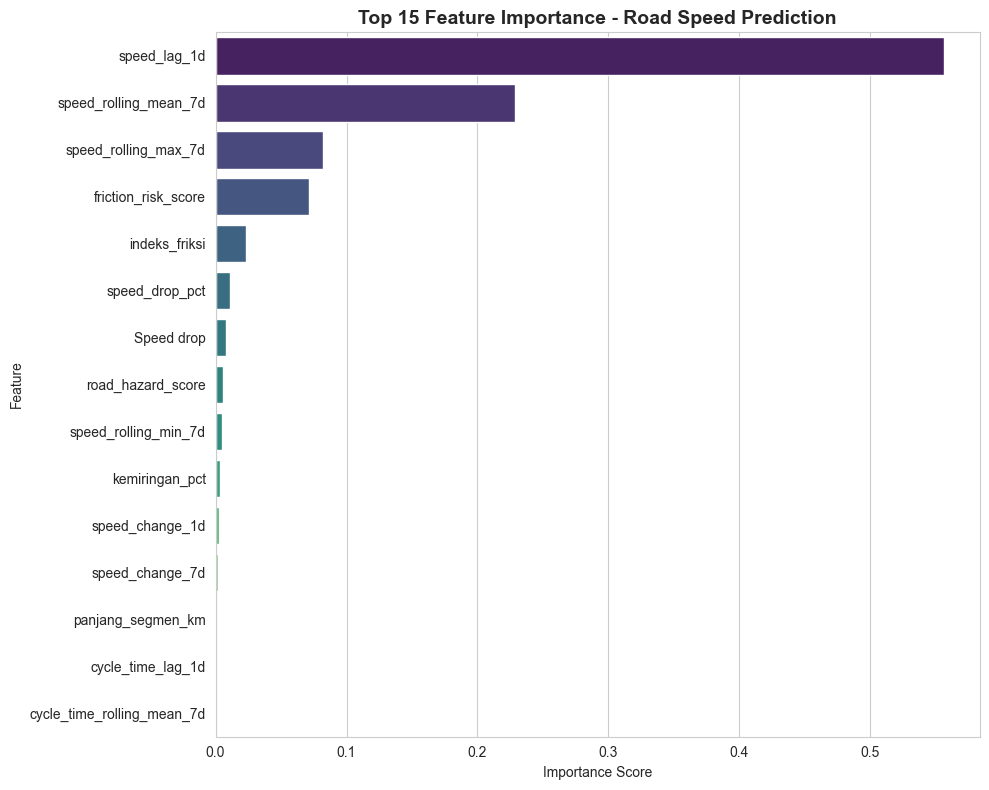


Top 10 Most Important Features:
              feature  importance
         speed_lag_1d    0.555860
speed_rolling_mean_7d    0.228558
 speed_rolling_max_7d    0.082074
  friction_risk_score    0.071429
        indeks_friksi    0.023444
       speed_drop_pct    0.011145
           Speed drop    0.007757
    road_hazard_score    0.005817
 speed_rolling_min_7d    0.004599
       kemiringan_pct    0.003367


In [11]:
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df.head(15), 
    x='importance', 
    y='feature', 
    palette='viridis'
)
plt.title('Top 15 Feature Importance - Road Speed Prediction', 
          fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# Save plot
plot_path = 'reports/figures/road_speed_feature_importance.png'
Path(plot_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
mlflow.log_artifact(plot_path)
plt.show()

print(f"\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Log top features to MLflow
for idx, row in importance_df.head(5).iterrows():
    mlflow.log_param(f'top_feature_{idx+1}', row['feature'])
    mlflow.log_metric(f'top_feature_{idx+1}_importance', row['importance'])


## 7. Residual Analysis

RESIDUAL ANALYSIS


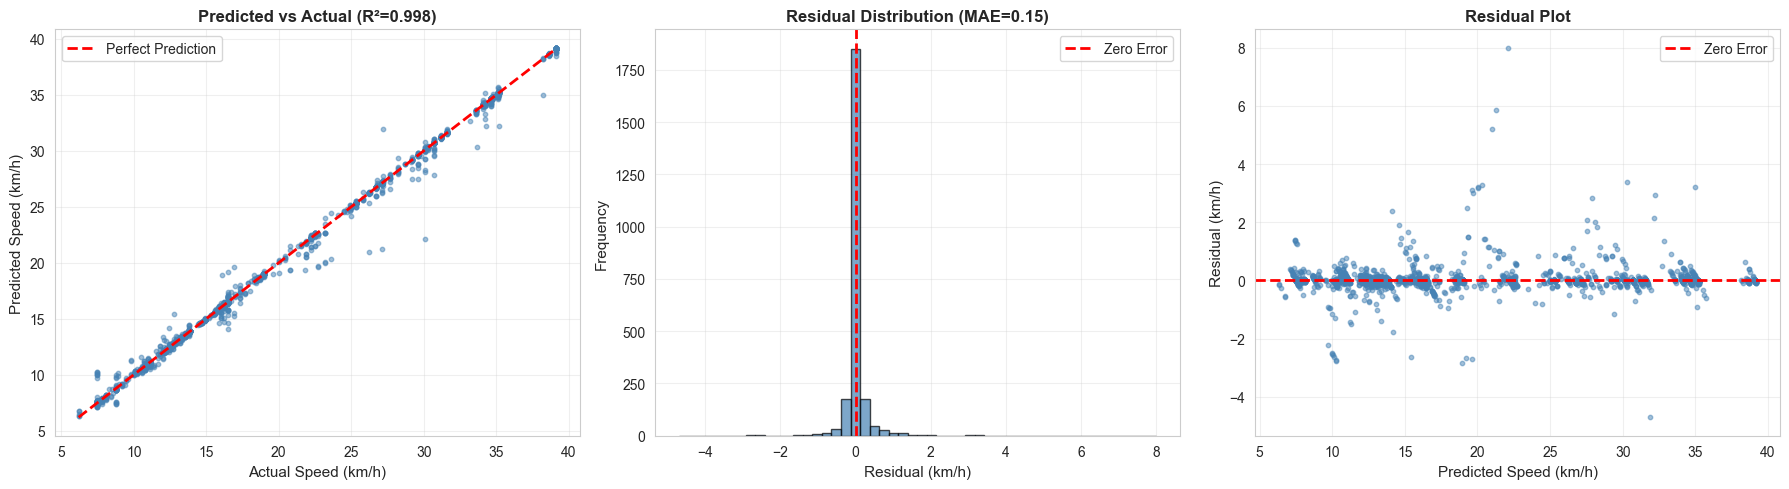


Residual Statistics:
  Mean: 0.025 km/h (should be ~0)
  Std Dev: 0.444 km/h
  Min: -4.705 km/h
  Max: 7.994 km/h
  Q1 (25%): -0.041 km/h
  Q3 (75%): 0.036 km/h


In [12]:
print("=" * 80)
print("RESIDUAL ANALYSIS")
print("=" * 80)

# Calculate residuals
residuals = y_test - y_test_pred

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Predicted vs Actual
axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=10, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Speed (km/h)', fontsize=11)
axes[0].set_ylabel('Predicted Speed (km/h)', fontsize=11)
axes[0].set_title(f'Predicted vs Actual (R²={test_r2:.3f})', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# 2. Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Residual (km/h)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Residual Distribution (MAE={test_mae:.2f})', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

# 3. Residual vs Predicted
axes[2].scatter(y_test_pred, residuals, alpha=0.5, s=10, color='steelblue')
axes[2].axhline(0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[2].set_xlabel('Predicted Speed (km/h)', fontsize=11)
axes[2].set_ylabel('Residual (km/h)', fontsize=11)
axes[2].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()

residual_path = 'reports/figures/road_speed_residual_analysis.png'
plt.savefig(residual_path, dpi=300, bbox_inches='tight')
mlflow.log_artifact(residual_path)
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.3f} km/h (should be ~0)")
print(f"  Std Dev: {residuals.std():.3f} km/h")
print(f"  Min: {residuals.min():.3f} km/h")
print(f"  Max: {residuals.max():.3f} km/h")
print(f"  Q1 (25%): {np.percentile(residuals, 25):.3f} km/h")
print(f"  Q3 (75%): {np.percentile(residuals, 75):.3f} km/h")


## 8. Model Summary & Next Steps

In [13]:
print(f"\n{'='*70}")
print(f"{'ROAD SPEED REGRESSION MODEL - BASELINE COMPLETE':^70}")
print(f"{'='*70}")

print(f"\nBusiness Objective:")
print(f"  Predict road speed for cycle time optimization")

print(f"\nModel Performance:")
print(f"  Algorithm: XGBoost Regressor")
print(f"  Test RMSE: {test_rmse:.3f} km/h {'ACHIEVED' if test_rmse < 5 else 'NOT MET'} (Target: <5 km/h)")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.3f} km/h")
print(f"  Test MAPE: {test_mape:.2f}%")

print(f"\nKey Insights:")
top_3_features = ', '.join(importance_df.head(3)['feature'].tolist())
print(f"  Top 3 Features: {top_3_features}")
print(f"  Model explains {test_r2*100:.1f}% of speed variance")
print(f"  Average prediction error: ±{test_mae:.2f} km/h")

print(f"\nDataset Summary:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Testing samples: {len(X_test):,}")
print(f"  Features used: {X_train.shape[1]}")

print(f"\nArtifacts Saved:")
print(f"  - Model logged to MLflow (Run ID: {run.info.run_id[:8]}...)")
print(f"  - Feature importance plot: reports/figures/road_speed_feature_importance.png")
print(f"  - Residual analysis plots: reports/figures/road_speed_residual_analysis.png")

print(f"\nNext Steps for ML Engineer A (Farhan):")
print(f"  1. Train Cycle Time Regression model")
print(f"  2. Train Road Risk Classification model")
print(f"  3. Week 5-6: Hyperparameter tuning with Optuna")
print(f"  4. Week 5-6: Ensemble modeling for improved accuracy")

print(f"{'='*70}")
print(f"\nModel ready for deployment and integration with cycle time optimization!")



           ROAD SPEED REGRESSION MODEL - BASELINE COMPLETE            

Business Objective:
  Predict road speed for cycle time optimization

Model Performance:
  Algorithm: XGBoost Regressor
  Test RMSE: 0.445 km/h ACHIEVED (Target: <5 km/h)
  Test R²: 0.9977
  Test MAE: 0.149 km/h
  Test MAPE: 0.93%

Key Insights:
  Top 3 Features: speed_lag_1d, speed_rolling_mean_7d, speed_rolling_max_7d
  Model explains 99.8% of speed variance
  Average prediction error: ±0.15 km/h

Dataset Summary:
  Training samples: 9,600
  Testing samples: 2,400
  Features used: 38

Artifacts Saved:
  - Model logged to MLflow (Run ID: 1fdf7c6f...)
  - Feature importance plot: reports/figures/road_speed_feature_importance.png
  - Residual analysis plots: reports/figures/road_speed_residual_analysis.png

Next Steps for ML Engineer A (Farhan):
  1. Train Cycle Time Regression model
  2. Train Road Risk Classification model
  3. Week 5-6: Hyperparameter tuning with Optuna
  4. Week 5-6: Ensemble modeling for impro